In [43]:
def show_most_red(api_key,api_secret,keyword,how_many_images,db_name,table_name,how_many_most_red):    
    if db_name=='':
        return print("nie podano nazwy bazwy danych, funkcja nie będzie działać")
    if table_name=='':
        return print("nie podano nazwy tabeli, funkcja nie będzie działać")
    
    #importowanie niezbędnych bibliotek
    import flickrapi
    from PIL import Image
    import requests
    from io import BytesIO
    import sqlite3
    import matplotlib.pyplot as plt

    #podłączenie do bazy istniejącej albo tworzenie nowej bazy
    #dalsze tworzenie nowej tabeli w bazie lub podłączenie do już istniejącej tabeli
    # UWAGA w danej sytuacji kod będzie działał w prypadku jeśli już istniejąca tabela ma taką samą strukturę
    conn = sqlite3.connect(db_name)
    c = conn.cursor()
    try: 
        c.execute('CREATE TABLE {}(Data,redness,greenness,blueness)'.format(table_name))
    except:
        print('tabela z takiej nazwoj już istnieje, dane będą importowane do tej tabeli\n a najbardziej czerwone zdjęcie/a zostanie wybrane spośród wszystkich zdjęć\n znajdujących się w tabeli\n tzn że zdjęcia będą powtarzali w przypadku zapytania z takim samym słowem kluczowym')
    conn.commit()
    conn.close()  

    #podłączenie do flicr i śćiąganie do listy urlów zdjęć odpowiadającym słowu kluczowemu
    flickr=flickrapi.FlickrAPI(api_key,api_secret, cache=True)
    if keyword=='':
        return print('nie podano tagu, funkcja nie będzie działać')############
    else:
        photos = flickr.walk(text=keyword,tag_mode='all',tags=keyword,extras='url_c',per_page=how_many_images,sort='relevance')
    urls = []
    i=1
    for photo in photos:   
        url = photo.get('url_c')
        if str(type(url))!="<class 'NoneType'>":
            urls.append(url)
            i=i+1    
        if i > how_many_images:
            break
            
    #podlączenie do bazy i ściągnięcie do bazy zdjęć które zamieszczone pod odpowiednim url
    #w liście która została zapełniona wcześniej
    #oraz sprawdzenie na ile oni są czerwone, ziełone, niebieskie
    conn = sqlite3.connect(db_name)
    c = conn.cursor()
    for i in range(0,len(urls)):
        response = requests.get(urls[i])
        img=Image.open(BytesIO(response.content))
        red,green,blue=img.getpixel((0,0))
        
        #tu czasami pojawia się błęd "division by zero" nie wiem z czego to wynika
        try:
            redness=red/(red+green+blue)
        except:
            print('pojawił się problęm z odczytaniem rgb zdjęcia numer {} przy obliczaniu czerwonośći'.format(i))
            redness=red/1
        try:
            greenness=green/(red+green+blue)
        except:
            print('pojawił się problęm z odczytaniem rgb zdjęcia numer {} przy obliczaniu zieloności'.format(i))
            greenness=green/1
        try:
            blueness=blue/(red+green+blue)
        except:
            print('pojawił się problęm z odczytaniem rgb zdjęcia numer {} przy obliczaniu niebieskości'.format(i))
            blueness=blue/1
            
        #zdjęcia w bazie danych będą chronione nie jako zdjęcia a jako kod tekstowy z powodu tego że ja nie 
        #znałazłęm odpowiedniego sposobu dla przechowywania obrazów w bazie danych
        c.execute('insert into {}(Data,redness,greenness,blueness) values (?, ?, ?,?)'.format(table_name),
              (requests.get(urls[i]).content, redness, greenness, blueness))
        conn.commit()
    conn.close()  
    
    #ściągnięcie z bazy top N najbardziej czerwonych zdjęć i wyświetlanie ich
    #tu się pojawiłtaki probłem że najbardziej czewone zdjęcie może być na oko nie aż takim czerwonym
    #szczerze mówić zakłądam że to wynika z tego że mój algorytm liczy to prawidłowo, ale miszanie rgb daje taki wynik,
    # czyli naprzykład mieszanie czerwonego i ziełonego daje zupełnie inny kolor który nie jest podobny ani na czerwony ani
    #na ziełony
    conn = sqlite3.connect(db_name)
    c = conn.cursor()
    images=[]
    c.execute('SELECT * from {} order by redness desc LIMIT {}'.format(table_name,how_many_most_red+1))
    rows = c.fetchall()
    for row in rows:
        images.append(Image.open(BytesIO(row[0])))
    conn.close() 

    for i in range(len(images)):
        plt.imshow(images[i].resize((256, 256)))
        plt.figure(i+1)
    plt.show()

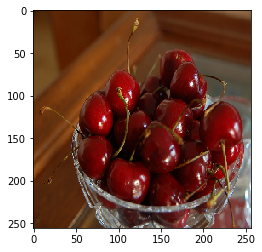

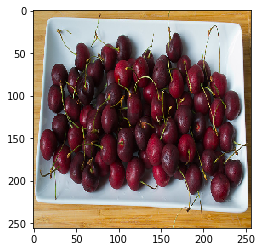

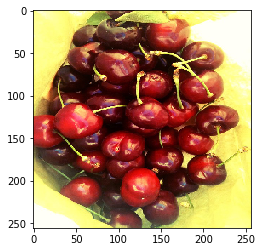

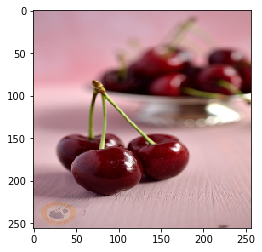

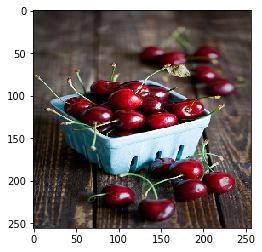

<Figure size 432x288 with 0 Axes>

In [44]:
api_key='c6a2c45591d4973ff525042472446ca2' 
api_secret= '202ffe6f387ce29b'


db_name='db_red'  #nazwa bazy danych 
table_name='table_red' #nazwa tabeli

keyword = 'cherry'          #słowo kluczowe
how_many_images=20       #ile zdjęć zostanie ściągnięte
how_many_most_red=5    #ile zdjęć zostanie wyświetlone

show_most_red(api_key,api_secret,keyword,how_many_images,db_name,table_name,how_many_most_red)